In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')

import aug_functions

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
2302903,74269,60226.2721,2,31.387892,0.690184,1,3.790512,0
4645794,148205,59933.1150,5,36.891739,3.448705,1,3.987288,0
7876335,249392,60662.1713,4,25.143715,2.056978,1,3.938479,0
6580390,208369,60549.1355,2,17.188635,0.998703,1,3.790512,1
1444455,46502,60226.2931,3,14.354440,1.043008,1,3.875155,1
1427624,45919,59896.0992,3,33.010712,1.599015,1,3.875155,0
6022246,190552,59924.0742,3,10.238943,1.116522,1,3.875155,1
10502320,332032,60605.1532,3,41.897377,1.262863,1,3.875155,1
228592,115336,60197.1446,4,172.730011,2.270667,1,3.938479,0
496430,246247,60635.0731,4,24.389662,2.345225,1,3.938479,1


In [4]:
good_object_ids = np.unique(good_objects_df.object_id)

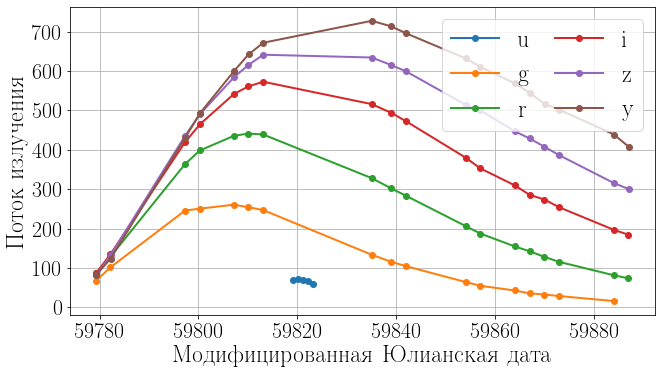

In [5]:
anobject = aug_functions.get_object(good_objects_df, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
augmentation_model = "GP"

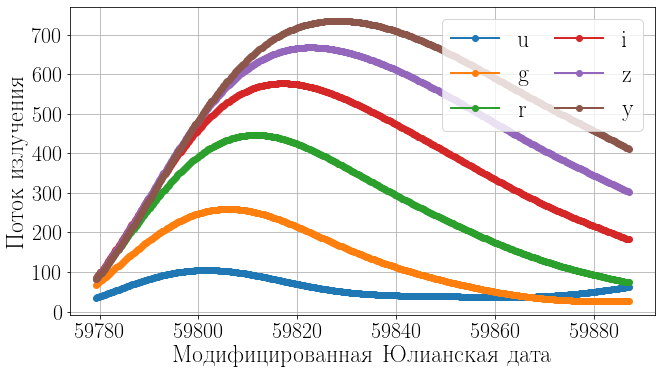

In [7]:
from sklearn.model_selection import train_test_split

anobject = aug_functions.get_object(good_objects_df, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = None
if augmentation_model == "GP":
    import gp_aug
    model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
elif augmentation_model == "NN_1":
    import single_layer_aug
    model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "FE":
    import features_aug
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
elif augmentation_model == "MLP":
    import mlp_reg_aug
    model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
elif augmentation_model == "RBF":
    import rbfnet_aug
    model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
else:
    raise ValueError("Unknown augmentation type: {}".format(augmentation_model))
    
# fit augmentation model
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                              anobject['mjd'].max(), 
                                                              n_obs=aug_functions.N_OBS)
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passbands_aug)
aug_functions.plot_light_curves(anobject_aug)

In [8]:
from tqdm.notebook import tqdm

all_data = []
all_target_classes = []
for good_id in tqdm(good_object_ids):
    anobject = aug_functions.get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    # initialize augmentation model
    model = None
    if augmentation_model == "GP":
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN_1":
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "RBF":
        model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")

    # fit augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # augmentation
    t_aug, flux_aug, flux_err, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

    data_array = flux_aug.reshape((aug_functions.N_PASSBANDS, aug_functions.N_OBS)).T
    all_data.append([data_array])
    
    true_class = int(anobject['class'].to_numpy()[0])
    all_target_classes.append(true_class)
    
all_data = np.array(all_data)
all_target_classes = np.array(all_target_classes)
print(all_data.shape, all_target_classes.shape)

  0%|          | 0/2508 [00:00<?, ?it/s]

(2508, 1, 500, 6) (2508,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    all_target_classes,
                                                    test_size=0.4,
                                                    random_state=179)

# normalize input
X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)

X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(10, 2))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(10, 2))
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(5, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3824, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 3824)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
import torch.optim as optim

net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [13]:
def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = test_outputs.item()
            if prob > 0.5:
                predicted = 1
            else:
                predicted = 0
            total += test_labels.size(0)
            correct += (predicted == test_labels.item())

    return correct / total

In [14]:
epochs = np.arange(100)

best_loss = float('inf')
best_state = None

for epoch in tqdm(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        for param in net.parameters():
            param.grad = None
        
        # forward + backward + optimize
        outputs = net(inputs).reshape(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    if (epoch + 1) % 10 == 0:
        print('[%5d] error: %.3f' % (epoch + 1, cur_loss))
    if cur_loss <= best_loss:
        best_loss = cur_loss
        best_state = net.state_dict()

net.load_state_dict(best_state)

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]

[   10] error: 0.682
[   20] error: 0.450
[   30] error: 0.254
[   40] error: 0.158
[   50] error: 0.128
[   60] error: 0.112
[   70] error: 0.098
[   80] error: 0.300
[   90] error: 0.148
[  100] error: 0.119
Finished Training


In [15]:
test_accuracy = get_model_accuracy(net, testloader)
train_accuracy = get_model_accuracy(net, trainloader)

print('Test accuracy of the network on the %d test images: %.4f' % 
      (X_test_norm.shape[0], test_accuracy))
print('Train accuracy of the network on the %d train images: %.4f' % 
      (X_train_norm.shape[0], train_accuracy))

Test accuracy of the network on the 1004 test images: 0.9462
Train accuracy of the network on the 1504 train images: 0.9641


In [16]:
y_test = []
y_probs = []
y_probs_0 = []
y_probs_1 = []

with torch.no_grad():
    for test_info in testloader:
        images, test_labels = test_info
        test_outputs = net(images)
        prob = test_outputs.item()
            
        true_class = int(test_labels.item())
        if true_class == 0:
            y_probs_0.append(prob)
        else:
            y_probs_1.append(prob)

        y_test.append(true_class)
        y_probs.append(prob)
        
y_test = np.array(y_test)
y_probs = np.array(y_probs)

In [17]:
N = len(y_probs)
sample_coeffs = np.random.randint(0, N, (10000, 1000))
sample_prob = y_probs[sample_coeffs]
sample_test = y_test[sample_coeffs]
sample_pred = sample_prob > 0.5

assert len(sample_test) == len(sample_prob)
assert len(sample_prob) == len(sample_pred)
T = len(sample_test)

accuracy = [(sample_pred[i] == sample_test[i]).mean() for i in range(T)]

In [18]:
assert np.array(y_probs).min() >= 0
assert np.array(y_probs).max() <= 1

from sklearn.metrics import log_loss
y_pred = np.array(y_probs) > 0.5
print("LogLoss = %.4f" % log_loss(y_test, y_pred))

logloss = [log_loss(sample_test[i], sample_pred[i]) for i in range(T)]

LogLoss = 1.6857


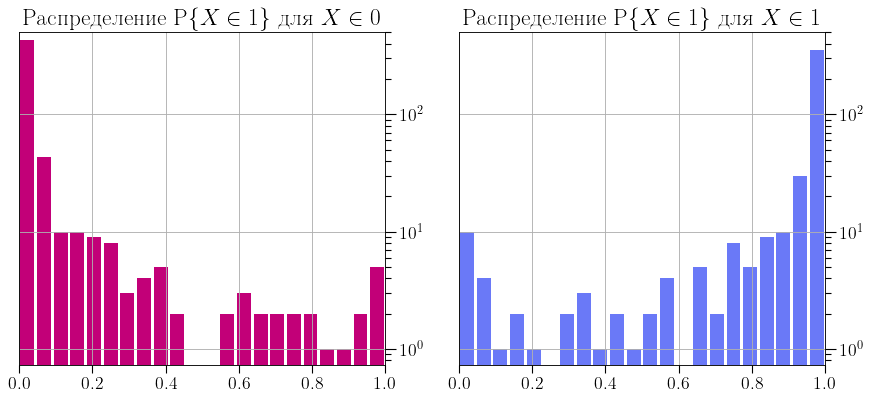

In [19]:
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

fig = plt.figure(dpi=80, figsize=(13, 5.5))

bins_number = 22
step = 1 / bins_number
hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
x = np.arange(0 + step/2, 1, step)

ax1 = fig.add_subplot(121)
ax1.yaxis.tick_right()
plt.title("Распределение P$\{X \in 1\}$ для $X \in 0$", fontsize=21, pad=7)

ax1.bar(x, hist_0, color="xkcd:magenta", width=0.038, log=True)
ax1.minorticks_on()
ax1.tick_params('y', length=10, width=1, which='major')
ax1.tick_params('y', length=5, width=1, which='minor')
ax1.tick_params('x', length=7, width=1, which='major')
ax1.tick_params('x', length=0, width=1, which='minor')
plt.xlim((0.0, 1.0))
plt.ylim((ax1.get_ylim()[0], int(ax1.get_ylim()[1]) // 100 * 100))
plt.grid(True)

ax2 = fig.add_subplot(122)
ax2.yaxis.tick_right()
plt.title("Распределение P$\{X \in 1\}$ для $X \in 1$", fontsize=21, pad=7)

ax2.bar(x, hist_1, color="xkcd:cornflower", width=0.038, log=True)
ax2.minorticks_on()
ax2.tick_params('y', length=10, width=1, which='major')
ax2.tick_params('y', length=5, width=1, which='minor')
ax2.tick_params('x', length=7, width=1, which='major')
ax2.tick_params('x', length=0, width=1, which='minor')
plt.xlim((0.0, 1.0))
plt.ylim(ax1.get_ylim())
plt.grid(True)

plt.show()

#fig.savefig("../pictures/CNN_output_hist_2_{}.pdf".format(augmentation_model),
#           bbox_inches='tight')

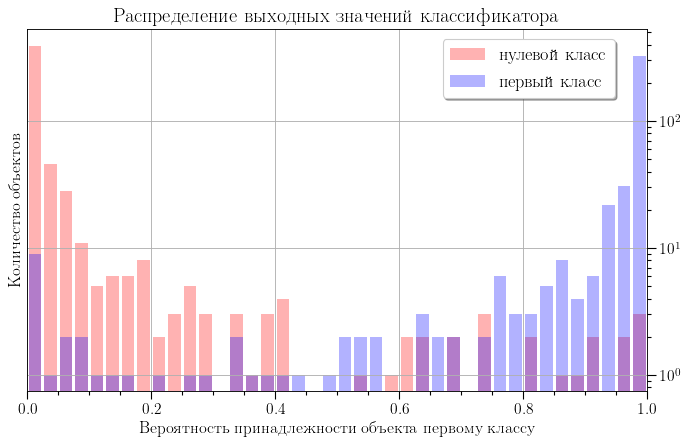

In [20]:
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

fig = plt.figure(dpi=80, figsize=(10, 6))
ax = fig.add_subplot(111)
ax.yaxis.tick_right()
plt.title("Распределение выходных значений классификатора", fontsize=18, pad=7)
plt.xlabel("Вероятность принадлежности объекта первому классу", fontsize=15)
plt.ylabel("Количество объектов", fontsize=15)

bins_number = 40
step = 1 / bins_number
hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
x = np.arange(0 + step/2, 1, step)

plt.bar(x, hist_0, color='r', width=0.02, log=True, label="нулевой класс", alpha=0.3)
plt.bar(x, hist_1, color='b', width=0.02, log=True, label="первый класс", alpha=0.3)

ax.minorticks_on()
ax.tick_params('y', length=8, width=1, which='major')
ax.tick_params('y', length=4, width=1, which='minor')
ax.tick_params('x', length=7, width=1, which='major')
ax.tick_params('x', length=4, width=1, which='minor')

plt.xlim((0.0, 1.0))
plt.grid(True)
plt.legend(frameon=True, loc=(0.67, 0.81), fontsize=16, shadow=0.1)

plt.show()

#fig.savefig("../pictures/CNN_output_hist_1_{}.pdf".format(augmentation_model),
#           bbox_inches='tight', pad_inches=0.01)

Распределение вероятностей принадлежности объекта к первому классу для нулевого и первого классов.

Test ROC-AUC: 0.9834, test PR-AUC: 0.9822


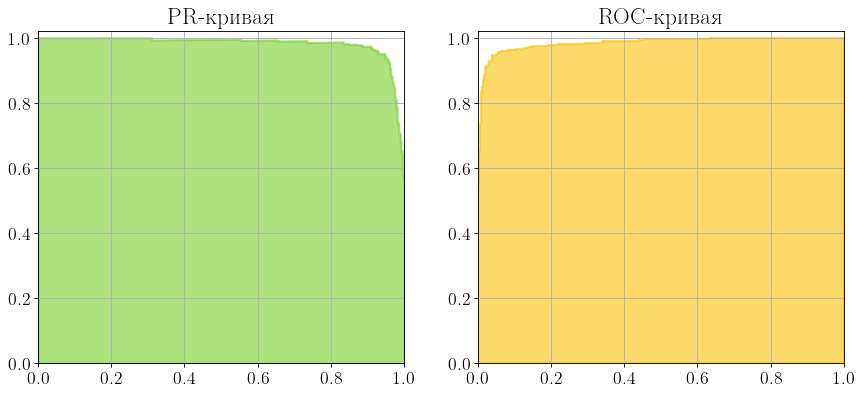

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                 average_precision_score(y_test, y_probs)))

auc_roc = [roc_auc_score(sample_test[i], sample_prob[i]) for i in range(T)]
auc_pr = [average_precision_score(sample_test[i], sample_prob[i]) for i in range(T)]

precision, recall, _ = precision_recall_curve(y_test, y_probs)

fig = plt.figure(dpi=80, figsize=(13, 5.5))
ax = fig.add_subplot(121)
plt.grid(True)
ax.set_title("PR-кривая", fontsize=21, pad=7)
ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.02)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ax = fig.add_subplot(122)
plt.grid(True)
ax.set_title("ROC-кривая", fontsize=21, pad=7)
ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:goldenrod", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.02)

plt.show()

#fig.savefig("../pictures/CNN_pr_roc_curves_{}.pdf".format(augmentation_model), 
#            bbox_inches='tight')

In [22]:
from seminars_07_roc_auc_compare_auc_delong_xu import delong_roc_variance
mean, std = delong_roc_variance(np.array(y_test), np.array(y_probs))
print("AUC-ROC: %.4f, %.4f" % (mean, np.sqrt(std)))

AUC-ROC: 0.9834, 0.0036


In [23]:
print("LogLoss:  mean = %.4f, std = %.4f" % (np.mean(logloss), np.std(logloss)))
print("Accuracy: mean = %.4f, std = %.4f" % (np.mean(accuracy), np.std(accuracy)))
print("AUC-ROC:  mean = %.4f, std = %.4f" % (np.mean(auc_roc), np.std(auc_roc)))
print("AUC-PR:   mean = %.4f, std = %.4f" % (np.mean(auc_pr), np.std(auc_pr)))

LogLoss:  mean = 1.6837, std = 0.2341
Accuracy: mean = 0.9513, std = 0.0068
AUC-ROC:  mean = 0.9834, std = 0.0036
AUC-PR:   mean = 0.9822, std = 0.0041
